# Project Overview

#### Business Case:

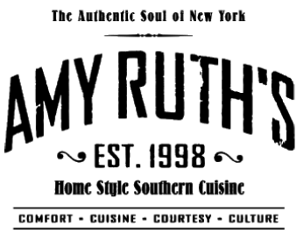

The stakeholder is a successful restaurant located in uptown Manhattan, New York City: “Amy Ruth's”. “Successful” is defined in this context as being in the top venues list of the foursquare data of that particular neighborhood. The restaurant owner wants to branch out and open a second restaurant in another larger metropolitan city or even in New York itself if appropriate. The goal of the project is to identify another neighborhood in an US city, which is similar to the one where “Amy Ruth’s” currently resides (Zip Code 10026).

#### Data and Processing:

The project requires three data sources:
- List of US cities: this information is extracted from Wikipedia with BeautifulSoup: https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population
- Neighborhood definition: postal zip codes of the individual cities are used as a surrogate for the classical neighborhood definition (i.e. neighborhood names). This is done for ease of use as obtaining neighborhood lists of several US cities is less consistent. Zip codes of US cities are available as a python library and database “uszipcode” https://pypi.org/project/uszipcode/
- The data characterizing a neighborhood is obtained through the Foursquare API
https://developer.foursquare.com/

Using the three data sources above a master table will be generated. First the zip codes are retrieved for the most populous cities in the US (>= 1M inhabitants) extracted from Wikipedia. Then venue data is extracted using the Foursquare API for each zip code. This information is added to a master table as one row per zip code and columns corresponding to venue types. A clustering will be performed on the one-hot encoded data. The cluster containing the neighborhood in which “Amy Ruth’s” is located is identified. This means that “Similarity” of neighborhoods is defined as neighborhoods belonging to the same cluster after a Kmeans clustering of all the collected neighborhood data. These neighborhoods of interest (zip codes) are then analyzed to ensure that there is no restaurant of the same type in the area to avoid direct competition. This then finally yields a list of zip codes in the US which could be of interest to open a new location of “Amy Ruth’s”.

### Set up environment and import libraries


In [1]:
!conda create --name myenv
#activate env
!activate myenv


Solving environment: done

## Package Plan ##

  environment location: /home/wsuser/.conda/envs/myenv



Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate myenv
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [2]:


!pip install bs4
from bs4 import BeautifulSoup

!pip install uszipcode
from uszipcode import SearchEngine

import numpy as np

import pandas as pd
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library

#!conda install -c conda-forge geopy --yes 
#!pip install goepy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print ("Libraries imported")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

### Download list of most populated cities in US

In [3]:
# get list of most populous US cities from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
html = requests.get(url).text


### Extract table with BeautifulSoup

In [4]:

# get all tables with BeautifulSoup
soup = BeautifulSoup(html,"html5lib")

tables = soup.find_all("table")
table_index= -1
table = None

# find the correct table 
for i,table in enumerate(tables):
    if "New York City" in str(table) and "Chicago" in str(table): #
        table_index = i
        #break # first table which 

if table_index >=0:
    table = tables[table_index]
    print ("Table found")
    #print (table)
else:
    print ("No valid table found")
    table = None



Table found


### Extract required data from table and generate a pandas dataframe for cities with at least 1M inhabitants

In [5]:

table_contents=[]

# loop over all cells in the table 
for i,row in enumerate(table.findAll('tr')): # orig: td
    
    #create dictionary for a given cell to be added to dataframe

    if not i:
        #skip header
        continue

    arr = (row.text).split("\n")
    cell = {}

    if len(arr)>17:
        #city 
        cell['City'] = arr[3].split("[")[0]
        #state 
        cell['State'] = arr[5].replace("\xa0","")
        #print (arr)
        cell['Size Estimate'] = int(arr[7].replace(",",""))

        #print (cell)
        
        table_contents.append(cell)

#print(table_contents)
# print(table_contents)
cities = pd.DataFrame(table_contents)

cities.head(10)

,City,State,Size Estimate
0,New York,New York,8336817
1,Los Angeles,California,3979576
2,Chicago,Illinois,2693976
3,Houston,Texas,2320268
4,Phoenix,Arizona,1680992
5,Philadelphia,Pennsylvania,1584064
6,San Antonio,Texas,1547253
7,San Diego,California,1423851
8,Dallas,Texas,1343573
9,San Jose,California,1021795


### Download zipcode database

In [6]:

#download zip code database
search = SearchEngine(simple_zipcode=True) # simple_zipcode=False


### Retrieve all zipcodes for cities with 1M or more inhabitants

In [7]:
#cities with at least one million inhabitants
tmpdata = []

for city, state,size in zip(cities["City"],cities["State"],cities["Size Estimate"]):
    if size > 1000000:
        #res = search.by_city_and_state(city, state)
        res = search.by_city(city=city, returns=0)
        if not len(res):
            print ("Error occurred for {}".format(city))
        else:
            #pcode = {}
            print ("Retrieved {} zip codes for {}".format(len(res),city))
            #city_zipcodes[city] = [z.zipcode for z in res]
            for z in res:
                pcode = {'City':city,'State':state,'Zipcode':z.zipcode,'Latitude':z.lat,'Longitude':z.lng}
                tmpdata.append(pcode)
city_wzipcodes =  pd.DataFrame(tmpdata)
city_wzipcodes.head()


Retrieved 99 zip codes for New York
Retrieved 64 zip codes for Los Angeles
Retrieved 58 zip codes for Chicago
Retrieved 106 zip codes for Houston
Retrieved 53 zip codes for Phoenix
Retrieved 56 zip codes for Philadelphia
Retrieved 68 zip codes for San Antonio
Retrieved 36 zip codes for San Diego
Retrieved 63 zip codes for Dallas
Retrieved 32 zip codes for San Jose


,City,State,Zipcode,Latitude,Longitude
0,New York,New York,10001,40.750,-73.990
1,New York,New York,10002,40.720,-73.990
2,New York,New York,10003,40.730,-73.990
3,New York,New York,10004,40.700,-74.020
4,New York,New York,10005,40.705,-74.005


Text(0, 0.5, 'Number of zip codes')

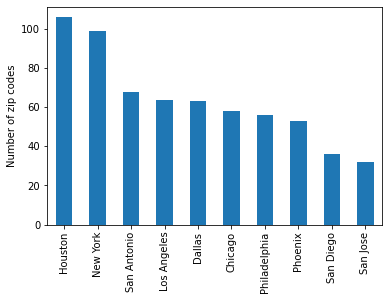

In [8]:

ax = city_wzipcodes["City"].value_counts().plot(kind='bar')
ax.set_ylabel("Number of zip codes")


Text(0.5, 0, 'City size in million')

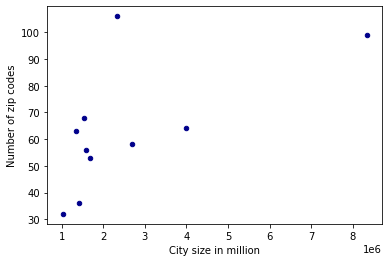

In [9]:
wx = pd.DataFrame(city_wzipcodes["City"].value_counts())
wx.rename(columns={"City": "value_counts"},inplace=True)

tmpcities = cities[cities["Size Estimate"]>1000000]

tmpcities.set_index(["City"],inplace=True)

tmpcities = tmpcities.join(wx)

tmpcities.head()


ax = tmpcities.plot.scatter(x='Size Estimate',
                      y='value_counts',
                      c='DarkBlue')
ax.set_ylabel("Number of zip codes")
ax.set_xlabel("City size in million")


### Set up foursquare information

In [10]:
# The code was removed by Watson Studio for sharing.

### Function to retrieve location data from foursquare

In [11]:

def getNearbyVenues(names, latitudes, longitudes, radius=500): 
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        #original 
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #results = requests.get(url).json()["response"]
        #if len(results) == 0:
        #    continue
        #results = results['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:

df = city_wzipcodes 

# clean up data 
df = df.dropna()
print (df.head())
print (df.shape)




       City     State Zipcode  Latitude  Longitude
0  New York  New York   10001    40.750    -73.990
1  New York  New York   10002    40.720    -73.990
2  New York  New York   10003    40.730    -73.990
3  New York  New York   10004    40.700    -74.020
4  New York  New York   10005    40.705    -74.005
(572, 5)


In [13]:

df_venues = getNearbyVenues(df["Zipcode"],df["Latitude"] , df["Longitude"], radius=1000) ## original radius=500
df_venues.head()


,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.75,-73.99,STORY,40.750866,-73.989272,Gift Shop
1,10001,40.75,-73.99,Louis Vuitton,40.750274,-73.988146,Boutique
2,10001,40.75,-73.99,Delta Sky360° Club,40.750564,-73.992824,Lounge
3,10001,40.75,-73.99,Krispy Kreme Doughnuts,40.749990,-73.992149,Donut Shop
4,10001,40.75,-73.99,Lush,40.749281,-73.987108,Cosmetics Shop


#### Display example venues for zip code "10026" where Amy Ruth's is located

In [14]:
print ((df_venues[df_venues["Zipcode"] == "10026"].head(20))["Venue"])

amy_ruths = df_venues[ df_venues["Venue"] == "Amy Ruth's" ]

#only one Amy Ruth's in entire data set
print (len(amy_ruths))
print (amy_ruths.head())

amy_ruths_category = str((amy_ruths["Venue Category"].values)[0])
print (amy_ruths_category)


2273                         Fieldtrip
2274          Central Park - North End
2275                       Bo's Bagels
2276                    Seasoned Vegan
2277                Little Bean Coffee
2278                       North Woods
2279                   iLoveKickboxing
2280                        Amy Ruth's
2281     Melba's American Comfort Food
2282                  67 Orange Street
2283    Cantina Taqueria & Tequila Bar
2284                     Farmers' Gate
2285                        The Winery
2286                    Shuteye Coffee
2287                     Levain Bakery
2288                            Safari
2289                        Monkey Cup
2290        Central Park - Harlem Hill
2291         tropical grill restaurant
2292              LoLo's Seafood Shack
Name: Venue, dtype: object
1
     Zipcode  Zipcode Latitude  Zipcode Longitude       Venue  Venue Latitude  \
2280   10026            40.801            -73.953  Amy Ruth's       40.802378   

      Venue Longitude       

### One hot encoding of venue information:


In [15]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
df_onehot['Zipcode'] = df_venues['Zipcode'] 

# move ipcode column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()


,Zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by zip code and by taking the mean of the frequency of occurrence of each category


In [16]:
df_grouped = df_onehot.groupby('Zipcode').mean().reset_index()
#print (df_grouped.head())
#print (df_grouped.shape)


In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### top 10 venues for each neighborhood.


In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zipcode'] = df_grouped['Zipcode']

for ind in np.arange(df_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()

#zipcodes_venues_sorted[zipcodes_venues_sorted["Zipcode"]=="10026"].head()



,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,00690,Sandwich Place,Asian Restaurant,Coworking Space,Bakery,Zoo Exhibit,Fabric Shop,Eye Doctor,Exhibit,Event Space,Event Service
1,10001,Korean Restaurant,Coffee Shop,Hotel,Dessert Shop,Pizza Place,Café,Gym / Fitness Center,American Restaurant,Boxing Gym,Italian Restaurant
2,10002,Cocktail Bar,Sandwich Place,Italian Restaurant,Pizza Place,Cosmetics Shop,Wine Shop,Asian Restaurant,Bakery,Coffee Shop,Australian Restaurant
3,10003,Wine Shop,Coffee Shop,Ice Cream Shop,Spa,Korean Restaurant,Bookstore,Japanese Restaurant,Italian Restaurant,Park,Salad Place
4,10004,Boat or Ferry,Park,Café,Mexican Restaurant,Monument / Landmark,Pier,Cocktail Bar,Bar,Heliport,Seafood Restaurant


### cluster neighborhoods, figure out good "k" value


5
10
15


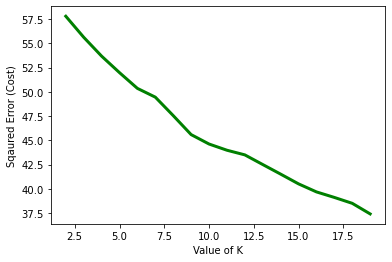

array([ 7, 10, 13, 13, 13, 13, 13, 13, 13, 13], dtype=int32)

In [19]:
import matplotlib.pyplot as plt 

# set number of clusters
cost =[]
k_values = [i for i in range(2,20)]

#sil = []

df_grouped_clustering = df_grouped.drop('Zipcode', 1)

# run k-means clustering
for kclusters in k_values:
    if kclusters %5==0 and kclusters > 0:
        print (kclusters)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
    #print (dir(kmeans))
    #print (kmeans.inertia_)
    cost.append(kmeans.inertia_)

# plot the cost against K values
plt.plot(k_values, cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



### re-cluster with appropriate "k"-value

In [20]:
# there is an elbow at k = 9

kmeans = KMeans(n_clusters=9, random_state=0).fit(df_grouped_clustering)


### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [21]:
# add clustering labels
zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

# merge df_grouped with df_data to add latitude/longitude for each zipcode
df_merged = df_merged.join(zipcodes_venues_sorted.set_index('Zipcode'), on='Zipcode')

df_merged = df_merged.dropna()

df_merged.head() # check the last columns!


,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,New York,10001,40.750,-73.990,7.0,Korean Restaurant,Coffee Shop,Hotel,Dessert Shop,Pizza Place,Café,Gym / Fitness Center,American Restaurant,Boxing Gym,Italian Restaurant
1,New York,New York,10002,40.720,-73.990,7.0,Cocktail Bar,Sandwich Place,Italian Restaurant,Pizza Place,Cosmetics Shop,Wine Shop,Asian Restaurant,Bakery,Coffee Shop,Australian Restaurant
2,New York,New York,10003,40.730,-73.990,7.0,Wine Shop,Coffee Shop,Ice Cream Shop,Spa,Korean Restaurant,Bookstore,Japanese Restaurant,Italian Restaurant,Park,Salad Place
3,New York,New York,10004,40.700,-74.020,7.0,Boat or Ferry,Park,Café,Mexican Restaurant,Monument / Landmark,Pier,Cocktail Bar,Bar,Heliport,Seafood Restaurant
4,New York,New York,10005,40.705,-74.005,7.0,Coffee Shop,Pizza Place,Cocktail Bar,American Restaurant,Falafel Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Café,Event Space


In [22]:
df_merged.shape

(546, 16)

### Find cluster information for respective zipcode

In [23]:
# Venuue type -> "Southern / Soul Food Restaurant"
#print (info)

cluster_nr =   ((df_merged[df_merged["Zipcode"]=="10026"])["Cluster Labels"].values )[0]

print ("Selected cluster has ID : {}".format(cluster_nr))


Selected cluster has ID : 7.0


In [24]:
cluster = df_merged[df_merged["Cluster Labels"]==cluster_nr]

print (cluster.shape)

cluster.head()



(339, 16)


,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,New York,10001,40.750,-73.990,7.0,Korean Restaurant,Coffee Shop,Hotel,Dessert Shop,Pizza Place,Café,Gym / Fitness Center,American Restaurant,Boxing Gym,Italian Restaurant
1,New York,New York,10002,40.720,-73.990,7.0,Cocktail Bar,Sandwich Place,Italian Restaurant,Pizza Place,Cosmetics Shop,Wine Shop,Asian Restaurant,Bakery,Coffee Shop,Australian Restaurant
2,New York,New York,10003,40.730,-73.990,7.0,Wine Shop,Coffee Shop,Ice Cream Shop,Spa,Korean Restaurant,Bookstore,Japanese Restaurant,Italian Restaurant,Park,Salad Place
3,New York,New York,10004,40.700,-74.020,7.0,Boat or Ferry,Park,Café,Mexican Restaurant,Monument / Landmark,Pier,Cocktail Bar,Bar,Heliport,Seafood Restaurant
4,New York,New York,10005,40.705,-74.005,7.0,Coffee Shop,Pizza Place,Cocktail Bar,American Restaurant,Falafel Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Café,Event Space


#### Number of zip codes of identified cluster

Text(0, 0.5, 'Number of zip codes')

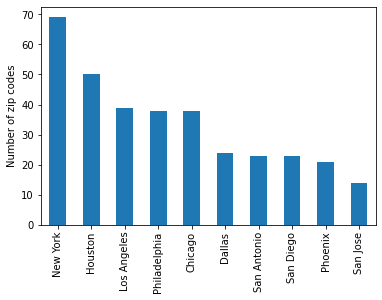

In [25]:

ax = cluster["City"].value_counts().plot(kind='bar')
ax.set_ylabel("Number of zip codes")



{'New York': 1.0, 'Los Angeles': 0.6290322580645161, 'Chicago': 0.6785714285714286, 'San Jose': 0.56, 'San Antonio': 0.39655172413793105, 'Phoenix': 0.4772727272727273, 'Philadelphia': 0.7450980392156863, 'Houston': 0.5, 'Dallas': 0.47058823529411764, 'San Diego': 0.7666666666666667}


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0, 0.5, 'Ratio of selected zip codes')

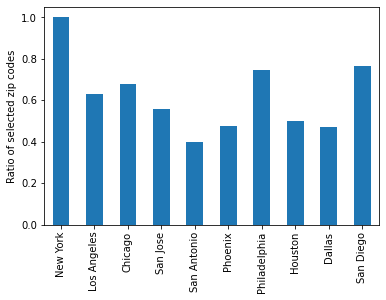

In [26]:
new = {}
w = cluster["City"].value_counts()
for c in set(cluster["City"]):
    ntot = len(df_merged[df_merged["City"] == c])
    nsel = len(cluster[df_merged["City"] == c])
    new[c] = nsel/ntot

df_tmp = pd.DataFrame.from_dict(new,orient='index' )
print (new)

ax = df_tmp[0].plot(kind='bar')
ax.set_ylabel("Ratio of selected zip codes")


## Postprocessing data set

### remove zip codes if they already contain a "Southern / Soul Food Restaurant" venue in the top 10


In [27]:
cluster.head()

,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,New York,10001,40.750,-73.990,7.0,Korean Restaurant,Coffee Shop,Hotel,Dessert Shop,Pizza Place,Café,Gym / Fitness Center,American Restaurant,Boxing Gym,Italian Restaurant
1,New York,New York,10002,40.720,-73.990,7.0,Cocktail Bar,Sandwich Place,Italian Restaurant,Pizza Place,Cosmetics Shop,Wine Shop,Asian Restaurant,Bakery,Coffee Shop,Australian Restaurant
2,New York,New York,10003,40.730,-73.990,7.0,Wine Shop,Coffee Shop,Ice Cream Shop,Spa,Korean Restaurant,Bookstore,Japanese Restaurant,Italian Restaurant,Park,Salad Place
3,New York,New York,10004,40.700,-74.020,7.0,Boat or Ferry,Park,Café,Mexican Restaurant,Monument / Landmark,Pier,Cocktail Bar,Bar,Heliport,Seafood Restaurant
4,New York,New York,10005,40.705,-74.005,7.0,Coffee Shop,Pizza Place,Cocktail Bar,American Restaurant,Falafel Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Café,Event Space


Text(0, 0.5, 'Frequency')

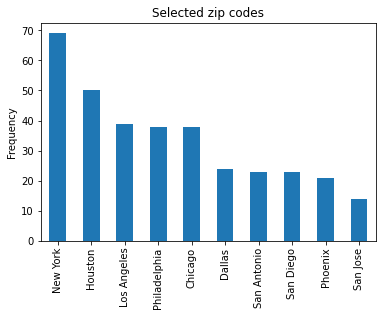

In [28]:

cols = [x for x in cluster.columns if "Venue" in x]

cluster_reduced = cluster [ (cluster[cols]!="Southern / Soul Food Restaurant").any(axis="columns") ]
ax = cluster_reduced["City"].value_counts().plot(kind='bar', title="Selected zip codes")

ax.set_ylabel("Frequency")



### remove zip codes if they contain no restaurant in the top 10 (unlikely place for a restaurant) or if there already are more than average restaurants as observed in the cluster


In [29]:
print  (cluster_reduced.shape)

# remove zip codes where there are no restaurants in the top 10 list:


tmpres = []

for i, j in cluster_reduced.iterrows():
    numrestaurants = (sum ([ 1 for s in (j[cols].values) if "Restaurant" in s]))
    tmpres.append(numrestaurants)

cluster_reduced["num_restaurants"] = tmpres
cluster_reduced.head()

cluster_reduced = cluster_reduced[cluster_reduced["num_restaurants"] > 0 ]


avg_restaurants = np.average(tmpres)

# remove zip codes where there are more than average restaurants in the top 10 list:


print ("Average number of restaurants in top 10 list {}".format(avg_restaurants))

cluster_reduced = cluster_reduced[ cluster_reduced["num_restaurants"]<avg_restaurants ]


print ( cluster_reduced.shape )




(339, 16)
Average number of restaurants in top 10 list 2.1799410029498527
(165, 17)


Text(0.5, 0, 'Number of restaurants in top 10 list')

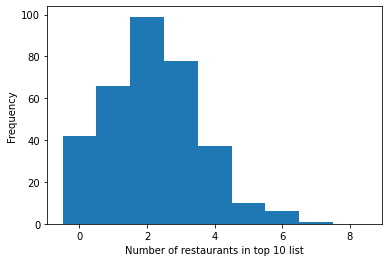

In [30]:
plt.hist(tmpres,bins=np.arange(10)-0.5) #, bins=n_bins)
plt.ylabel("Frequency")

plt.xlabel("Number of restaurants in top 10 list")


Text(0, 0.5, 'Frequency')

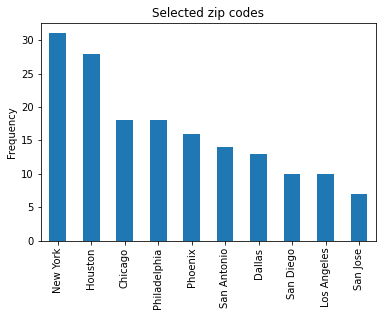

In [31]:
ax = cluster_reduced["City"].value_counts().plot(kind='bar', title="Selected zip codes")
ax.set_ylabel("Frequency")


### For the remaining zip codes find the most similar neighborhood per city as measured by euclidean distance of the one-hot encoded vector to zip code "10026" where "Amy Ruth's" resides


In [32]:


df_sel = df_grouped[ df_grouped["Zipcode"] == "10026" ]
df_sel = df_sel.drop('Zipcode', 1)


final_zipcodes = []
for city in set(cluster_reduced["City"].values):
    tmpx = cluster_reduced [ cluster_reduced["City"] == city ]["Zipcode"]
    minval = 1e1000
    minzip = ""
    for z in tmpx.values:
        df_cur = df_grouped[ df_grouped["Zipcode"] == z ]
        df_cur = df_cur.drop('Zipcode', 1)
        sqdist =  np.sum ([ (x1-x2)*(x1-x2) for x1,x2 in zip(df_sel.values,df_cur.values)] ) 
        #print (sqdist)
        if sqdist < minval:
            minzip = z
            minval = sqdist
    
    #final_zipcodes.append([minzip,sqdist])
    final_zipcodes.append(minzip)

print (final_zipcodes)

['10023', '90042', '60647', '95110', '78229', '85004', '19107', '77201', '75226', '92104']


In [33]:
#only one zip code per city left:

final_selection = cluster_reduced[cluster_reduced["Zipcode"].isin(final_zipcodes)]

#final_selection["City"].value_counts().plot(kind='bar', title="Selected zip codes")



### Show information on selected zip code for San Diego:




In [34]:
city="San Diego"
example_zipcode = final_selection[ final_selection["City"] == city ]["Zipcode"].values[0]
print ("Selected zip code {}".format(example_zipcode))

example_info = final_selection[ final_selection["City"] == city ]
print (example_info.head())


Selected zip code 92104
          City       State Zipcode  Latitude  Longitude  Cluster Labels  \
508  San Diego  California   92104     32.74    -117.13             7.0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
508               Brewery           Pizza Place                  Café   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
508           Coffee Shop          Liquor Store                  Park   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
508        Breakfast Spot            Taco Place    Mexican Restaurant   

    10th Most Common Venue  num_restaurants  
508          Grocery Store                1  


### display information for example zip code on map with surrounding area with a larger icon

In [35]:
# create map
#address = 'San Jose, California'

#geolocator = Nominatim(user_agent="us_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude

map_clusters = folium.Map(location=[example_info["Latitude"].values, example_info["Longitude"].values], zoom_start=12)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Zipcode'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    rad = 5 
    if poi in final_zipcodes:
        rad = 20
    folium.CircleMarker(
        [lat, lon],
        radius=rad,
        popup=label,
        color=rainbow[(int(cluster))-1],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [36]:
map_clusters


# Final shortlist of suggested, most similar neighborhoods based on Foursquare data:

In [37]:
final_selection.head(100)

,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,num_restaurants
21,New York,New York,10023,40.7800,-73.9800,7.0,Coffee Shop,Wine Shop,Italian Restaurant,Bakery,Ice Cream Shop,Café,Yoga Studio,Park,Exhibit,Sushi Restaurant,2
138,Los Angeles,California,90042,34.1100,-118.1900,7.0,Mexican Restaurant,Café,Trail,Pizza Place,Burger Joint,Bar,Coffee Shop,Bakery,Juice Bar,Chinese Restaurant,2
207,Chicago,Illinois,60647,41.9200,-87.7000,7.0,Cocktail Bar,Mexican Restaurant,Bar,Coffee Shop,Pizza Place,Brewery,Ice Cream Shop,Park,Café,New American Restaurant,2
326,Houston,Texas,77201,29.7655,-95.3658,7.0,Park,Coffee Shop,Burger Joint,Cocktail Bar,Bar,Hotel,Southern / Soul Food Restaurant,Taco Place,Concert Hall,Mexican Restaurant,2
330,Phoenix,Arizona,85004,33.4500,-112.0700,7.0,Coffee Shop,Hotel,American Restaurant,Bar,Cocktail Bar,Pizza Place,Lounge,Breakfast Spot,Salon / Barbershop,New American Restaurant,2
385,Philadelphia,Pennsylvania,19107,39.9500,-75.1600,7.0,Coffee Shop,Bakery,Italian Restaurant,Hotel,Pub,Wine Bar,Sandwich Place,Vegetarian / Vegan Restaurant,Taco Place,Gym,2
466,San Antonio,Texas,78229,29.5100,-98.5700,7.0,Coffee Shop,Pharmacy,Sandwich Place,Bar,Hotel,Video Store,Bank,Pizza Place,Mexican Restaurant,Convenience Store,1
508,San Diego,California,92104,32.7400,-117.1300,7.0,Brewery,Pizza Place,Café,Coffee Shop,Liquor Store,Park,Breakfast Spot,Taco Place,Mexican Restaurant,Grocery Store,1
569,Dallas,Texas,75226,32.7800,-96.7800,7.0,Bar,Dive Bar,American Restaurant,Coffee Shop,Rock Club,Gym,Music Venue,BBQ Joint,Burger Joint,Cocktail Bar,1
606,San Jose,California,95110,37.3400,-121.9100,7.0,Coffee Shop,Mexican Restaurant,Bakery,Thrift / Vintage Store,Sandwich Place,Pizza Place,Grocery Store,Burger Joint,Gym / Fitness Center,Shipping Store,1
